เราจะสร้าง Machine Learning เรียนรู้จากข้อมูล x, y ที่ให้มา เพื่อทำ Linear Regression สร้างฟังก์ชันขึ้นมาใหม่ ที่สามารถทำงานสร้าง Output ได้ใกล้เคียงข้อมูลตัวอย่าง โดยใช้วิธี Stochastic Gradient Descent (SGD) Optimization

# 0. Import Library

Import Library ที่จะจำเป็น

In [1]:
%matplotlib inline
from fastai.basics import *

# 1. Generate x

สร้างข้อมูล x เป็นเลข 0 ถึง 29 เอาไว้เป็นข้อมูล input ให้ฟังก์ชัน จะได้เอาไว้พล็อตกราฟดู

* Column แรก เป็นเลข 0 - 29 เอาไว้คุณกับความชัน (x<sub>1</sub>)
* Column ที่สองเป็น เลข 1, 1, 1, ... อย่างเดียว เอาไว้คุณกับจุดตัด จะได้คงค่าจุดตัดไว้เหมือนเดิม (x<sub>0</sub> เป็น 1 เสมอ)

ลองดู x ใน 10 แถวแรก

In [2]:
n = 30
x = torch.ones(n, 2)
x[:,0] = torch.arange(n, out=torch.FloatTensor())
x

tensor([[ 0.,  1.],
        [ 1.,  1.],
        [ 2.,  1.],
        [ 3.,  1.],
        [ 4.,  1.],
        [ 5.,  1.],
        [ 6.,  1.],
        [ 7.,  1.],
        [ 8.,  1.],
        [ 9.,  1.],
        [10.,  1.],
        [11.,  1.],
        [12.,  1.],
        [13.,  1.],
        [14.,  1.],
        [15.,  1.],
        [16.,  1.],
        [17.,  1.],
        [18.,  1.],
        [19.,  1.],
        [20.,  1.],
        [21.,  1.],
        [22.,  1.],
        [23.,  1.],
        [24.,  1.],
        [25.,  1.],
        [26.,  1.],
        [27.,  1.],
        [28.,  1.],
        [29.,  1.]])

# 2. สมมติโจทย์

สมมติ โจทย์ คือ สมการเส้นตรง y = mx + b โดยที่ m = 2 และ b = 5 เราใส่ค่า x ตั้งแต่ 0-29 จะได้ค่า y ดังนี้

In [3]:
y = (2. * x[:, 0]) + 5.
y

tensor([ 5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25., 27., 29., 31.,
        33., 35., 37., 39., 41., 43., 45., 47., 49., 51., 53., 55., 57., 59.,
        61., 63.])

นำมาพล็อตกราฟ จะได้กราฟเส้นตรง ความชัน เท่ากับ 2 จุดตัดแกน y เท่ากับ 5

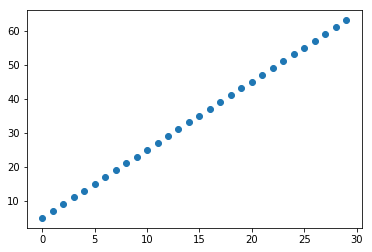

In [4]:
plt.scatter(x[:,0], y)

## 2.1 เพิ่ม Noise

เพื่อให้เหมือนข้อมูลในโลกความเป็นจริง เราจะใส่ noise เข้าไปในข้อมูล จะได้เพิ่มความยากขึ้นอีกนิดนึง โดย noise จะอยู่ในช่วง -5 ถึง 5

In [5]:
noise = (torch.rand_like(y) * 10.) - 5.
noise

tensor([ 0.0462,  4.0523,  1.1501,  4.1260, -2.1477,  4.0931,  3.9803,  2.9366,
        -4.4267, -3.4924, -2.2114, -2.6887,  1.7322, -3.1937,  4.9270,  2.1090,
         3.6213, -2.6147,  4.7667,  1.3146,  1.0993,  0.0218,  4.9809,  1.8263,
         3.9967, -1.2110, -4.3116, -4.6972, -3.7320, -4.8263])

นำ noise มาใส่ใน y

In [6]:
y = y + noise
y

tensor([ 5.0462, 11.0523, 10.1501, 15.1260, 10.8523, 19.0931, 20.9803, 21.9366,
        16.5733, 19.5076, 22.7886, 24.3113, 30.7322, 27.8063, 37.9270, 37.1090,
        40.6213, 36.3853, 45.7667, 44.3146, 46.0993, 47.0218, 53.9809, 52.8263,
        56.9967, 53.7890, 52.6884, 54.3028, 57.2680, 58.1737])

พล็อตกราฟดูจะเห็นว่า ข้อมูลมีความเหมือนจริงมากขึ้น แต่ก็ยังดูเป็นเส้นตรงอยู่

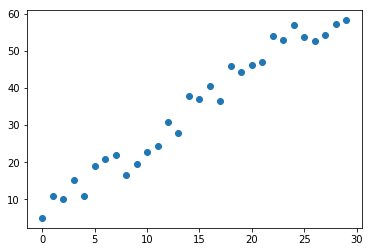

In [7]:
plt.scatter(x[:,0], y)

# 3. Loss Function

เรามากำหนด loss function ด้วยฟังก์ชัน Mean Squared Error คือการนำ yhat (y hat) ที่เราคำนวนได้ และ y ของจริง มาลบกัน แล้วยกกำลังสอง เพื่อให้เครื่องหมายลบหายไป และหาค่าเฉลี่ยของทั้งหมด

In [8]:
def mse(yhat, y): 
    return ((y-yhat)**2).mean()

# 4. Linear Regression

เราจะสร้างฟังก์ชันเส้นตรงขึ้นมา 1 ฟัง์ชัน เพื่อให้ทำงานนี้ y = mx + b โดยสุ่มค่าเริ่มต้น m, b ขึ้นแล้ว แล้วค่อย ๆ ปรับไปทีละนิด เรียกว่า Linear Regression

## 4.1 Initialization

สมมติว่าเราไม่รู้โจทย์ ไม่รู้มาก่อนว่า ค่า m และ b คืออะไร เราเห็นแต่ข้อมูล x และ y เราจะสมมติให้ค่าเริ่มต้นของโมเดลของเราเป็น m = -2 และ b = 4

In [9]:
a = tensor([-2., 4.])

# 5. yhat

นำมาคูณกับ x ออกมาเป็น yhat

In [10]:
yhat = x @ a
yhat

tensor([  4.,   2.,   0.,  -2.,  -4.,  -6.,  -8., -10., -12., -14., -16., -18.,
        -20., -22., -24., -26., -28., -30., -32., -34., -36., -38., -40., -42.,
        -44., -46., -48., -50., -52., -54.])

แล้วนำมาพล็อตกราฟเทียบกัน ระหว่าง y และ yhat

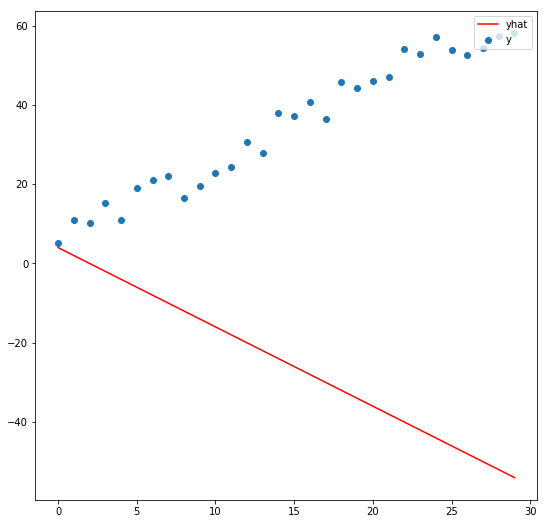

In [11]:
fig,ax = plt.subplots(figsize=(9, 9))
ax.scatter(x[:,0], y, label="y")
ax.plot(x[:,0], yhat, label="yhat", color='red')
ax.legend(loc='upper right')

นำ yhat และ y มาคำนวน loss ด้วย mse 

In [12]:
loss = mse(yhat, y)
loss

tensor(4669.4512)

# 6. Training Loop

ประกาศให้ a เป็น Parameter คือจะให้ระบบคำนวน หา Gradient ให้อัตโนมัติ requires_grad=True

In [13]:
a = torch.nn.Parameter(a)
a

Parameter containing:
tensor([-2.,  4.], requires_grad=True)

กำหนดฟังก์ชัน สำหรับคำนวน yhat, loss แล้วอัพเดท a ด้วย การลบด้วย Gradient (a.grad) * Learning Rate (lr) เรียกว่า Stochastic Gradient Descent (SGD)

*print loss, ค่า a, และ ค่า a.grad*

In [14]:
def update():
    yhat = x @ a
    loss = mse(yhat, y)
    loss.backward()
    with torch.no_grad():
        if i % 10 == 0: print(f"loss={loss}, a={a.data}, a.grad={a.grad}")
        a.sub_(lr * a.grad)        
        a.grad.zero_()

# 7. เทรนไป 100 Epoch

กำหนดค่า lr แล้ววน Loop เทรน ให้อัพเดท a ไปเรื่อย ๆ โดยดูข้อมูล x, y ทั้งหมด 100 รอบ เรียกว่า 100 Epoch

In [15]:
lr = 1e-4
for i in range(100):
    update()

loss=4669.451171875, a=tensor([-2.,  4.]), a.grad=tensor([-2304.7966,  -118.7485])
loss=1446.64501953125, a=tensor([-0.2063,  4.0927]), a.grad=tensor([-1279.1018,   -66.5458])
loss=453.9816589355469, a=tensor([0.7891, 4.1448]), a.grad=tensor([-709.8534,  -37.5736])
loss=148.2283172607422, a=tensor([1.3416, 4.1744]), a.grad=tensor([-393.9275,  -21.4940])
loss=54.05130386352539, a=tensor([1.6481, 4.1915]), a.grad=tensor([-218.5925,  -12.5697])
loss=25.04222869873047, a=tensor([1.8182, 4.2016]), a.grad=tensor([-121.2836,   -7.6165])
loss=16.105655670166016, a=tensor([1.9126, 4.2078]), a.grad=tensor([-67.2784,  -4.8672])
loss=13.35164737701416, a=tensor([1.9650, 4.2119]), a.grad=tensor([-37.3060,  -3.3410])
loss=12.501952171325684, a=tensor([1.9940, 4.2148]), a.grad=tensor([-20.6719,  -2.4937])
loss=12.238800048828125, a=tensor([2.0100, 4.2171]), a.grad=tensor([-11.4400,  -2.0231])


สังเกต loss ลดลงอย่างรวดเร็ว ค่า a ก็เข้าใกล้ โจทย์

# 8. Inference

นำโมเดลที่เราเทรนได้ มาใช้จริง ด้วยการคำนวน yhat จาก a ที่เราเทรนได้ 

In [16]:
yhat = x@a

พล็อตกราฟเปรียบเทียบ หลังเทรนเรียบร้อยแล้ว

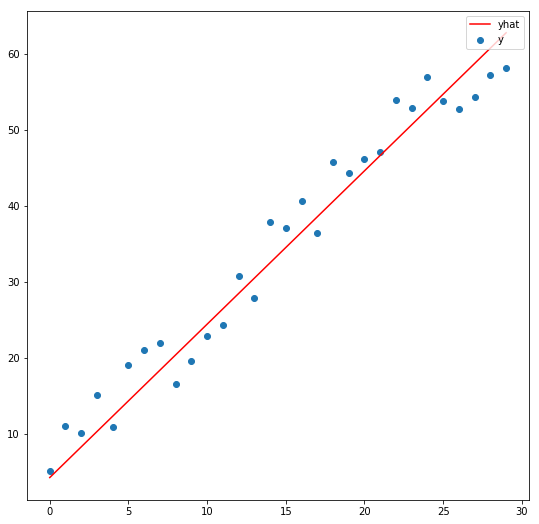

In [17]:
fig,ax = plt.subplots(figsize=(9, 9))
ax.scatter(x[:,0], y, label="y")
ax.plot(x[:,0], yhat, label="yhat", color='red')
ax.legend(loc='upper right')

เราจะได้ค่า a ดังนี้ ใกล้เคียงกับโจทย์ โดยที่เราเรียนรู้จากข้อมูล x, y เท่านั้น

In [18]:
a

Parameter containing:
tensor([2.0189, 4.2190], requires_grad=True)

# 9. สรุป

1. นี่เป็นตัวอย่างแบบง่ายที่สุด ซับซ้อนน้อยที่สุด เราสามารถ เพิ่ม Parameter จาก 2 ตัวเป็นร้อย พัน ไปจนถึง หลายล้านตัว สร้างฟังก์ชันที่ซับซ้อนมากขึ้นได้
1. ในการอัพเดท Parameter มีอัลกอริทึมที่จะช่วยให้ Converge เร็วขึ้นได้อีกมากกว่า แค่ SGD ตรง ๆ
1. เวลาเราเทรนข้อมูลจริง ๆ มักจะแบ่งข้อมูล ป้อนให้โมเดล ทีละ mini-batch ไม่ได้ป้อนทีเดียวหมดแบบนี้

# 10. Credit

* https://course.fast.ai/videos/?lesson=2
* https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html
* https://matplotlib.org/3.1.1/tutorials/introductory/pyplot.html